In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (<ipython-input-1-583db37e43a6>, line 17)

In [2]:
import numpy as np
import os
import glob
import time

# importing data
event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}

test_dir = os.path.join('/kaggle/input/dcl-ds2new/DCL_ds2new/test')  
train_dir = os.path.join('/kaggle/input/dcl-ds2new/DCL_ds2new/train')

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(test_dir, f'*{search_string}*')
all_test_files = glob.glob(search_pattern)
test_files = [file for file in all_test_files if not file.endswith('d')]

search_pattern = os.path.join(train_dir, f'*{search_string}*')
all_train_files = glob.glob(search_pattern)
train_files = [file for file in all_train_files if not file.endswith('d')]

print(len(test_files))
print(test_files[:10])

print(len(train_files))
print(train_files[:10])
import json

json_data_path = '/kaggle/input/dcl-ds2new/DCL_ds2new/params.json'
with open(json_data_path, 'r') as file:
    try:
        json_data = json.load(file)
        print(json_data)
    except json.JSONDecodeError:
        print(f"Error: JSON decode failed for file '{file_path}'")


692
['/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn170113420', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn141216438', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn131029420', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn171010875', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SGR_bn160715298', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn220407167', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/TGF_bn140628393', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/TGF_bn180607061', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/TGF_bn180922713', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn140204056']
2800
['/kaggle/input/dcl-ds2new/DCL_ds2new/train/SGR_bn160626724', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/GRB_bn230911329', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/TGF_bn160416676', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/GRB_bn150322066', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/GRB_bn120312671', '/kaggle/input/dcl-ds2new/DCL_ds2new/train/TGF_bn110606097', '/kaggle/input

In [3]:
dno = json_data['number of data points']

try:
    chrn = len(json_data['channel ranges'])
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
dno_list = (chrn * len(bin_list)) * [dno]
data_total = sum(dno_list)
check_data = np.loadtxt(train_files[1], delimiter='\t').astype(np.int32)
len_data = len(check_data)
print(dno_list)

if data_total == len_data and len(dno_list) == len(bin_list) * chrn:
    print('bin edges calculated correctly')
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
print('channel range no',chrn)
print('number of data points',dno)
print('time interval',t)

[499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499]
bin edges calculated correctly
channel range no 2
number of data points 499
time interval n/a


In [4]:
import numpy as np

def process_file(file, X, Y, event_counter, dno_list):
    """
    Processes a single file and adds its data to the dataset.
    file: path to the file to be processed
    X: list of datasets to be appended to
    Y: list of labels of data
    event_counter: dictionary counting events
    dno_list: list of number of data points in each binning as calculated previously
    
    Returns updated X, Y, and event_counter
    """
    # Fetch data from file and check if label is considered
    event_type, event_name = file.split('/')[-1].split('_')
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.int32)
    
    if event_type not in event_counter:
        return X, Y, event_counter
    
    y = [0, 0, 0, 0]
    
    # Setting and updating Y
    for key, value in event_types.items():
        if value in file.split('\\')[-1]:
            y[key - 1] = 1
            Y.append(y)
            event_counter[value] += 1
    
    channel_1_data = []
    channel_2_data = []

    # Initialize lists to hold data slices
    for i in range(0,len(loaded_data),998):
        channel_1_data.extend(loaded_data[i:i+499])
        channel_2_data.extend(loaded_data[i+499:i+998])
    
    X.append([channel_1_data, channel_2_data])
    
    return X, Y, event_counter

In [5]:
# initializing train and test sets
X_train = []
Y_train = []
train_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

X_test = []
Y_test = []
test_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

# print(process_file(train_files[1],X_train,Y_train,train_event_counter))

# processing train and test data sets
for file in train_files:
    X_train,Y_train,train_event_counter = process_file(file,X_train,Y_train,train_event_counter,dno_list)
print('training events\n',train_event_counter)
print('total events : ', sum([i for i in train_event_counter.values()]))
Y_train = np.array(Y_train)
X_train = np.array(X_train)
print('shape of Y_train', Y_train.shape)
print('shape of X_train', X_train.shape)

for file in test_files:
    X_test,Y_test,test_event_counter = process_file(file,X_test,Y_test,test_event_counter,dno_list)
print('testing events\n',test_event_counter)
print('total events : ', sum([i for i in test_event_counter.values()]))
Y_test = np.array(Y_test)
X_test = np.array(X_test)
print('shape of Y_test', Y_test.shape)
print('shape of X_test', X_test.shape)
print(X_train[1:2])


training events
 {'GRB': 800, 'TGF': 800, 'SGR': 400, 'SFLARE': 800}
total events :  2800
shape of Y_train (2800, 4)
shape of X_train (2800, 2, 3493)
testing events
 {'GRB': 200, 'TGF': 200, 'SGR': 92, 'SFLARE': 200}
total events :  692
shape of Y_test (692, 4)
shape of X_test (692, 2, 3493)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [6]:
import tensorflow as tf
from keras import layers, models,regularizers,Sequential
from keras.callbacks import EarlyStopping , ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, LSTM, GRU, Bidirectional,BatchNormalization

In [7]:
tf.random.set_seed(42)

# Build the CNN model
model = Sequential()
#model.add(layers.Conv1D(32, 1, activation='relu', input_shape=(2,3493),kernel_regularizer=regularizers.l2(0.03)))

model.add(Input(shape=(2,3493)))

model.add(layers.Conv1D(512,1, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(512,2, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.MaxPooling1D((1)))
model.add(LSTM(1024, return_sequences=True ,kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.03)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(4, activation='softmax'))
model.summary()

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3,min_lr=1e-6,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',patience=25,min_delta=0.001, restore_best_weights=True, verbose=1)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epoch = 100
# Train the model
history = model.fit(X_train, Y_train, epochs=epoch, batch_size=128, validation_split=0.2, callbacks=[lr_scheduler])

# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f'\n accuracy on training data: {train_acc} \n \n')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print(f'accuracy on test data: {test_acc}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2, 512)              │       1,788,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 512)              │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 1024)             │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 1024)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,922,308 (37.85 MB)

 Trainable params: 9,922,308 (37.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5859 - loss: 82.5042 - val_accuracy: 0.8250 - val_loss: 44.1540 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7973 - loss: 37.0407 - val_accuracy: 0.8375 - val_loss: 21.3922 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8028 - loss: 18.6923 - val_accuracy: 0.7589 - val_loss: 12.6562 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7997 - loss: 11.4996 - val_accuracy: 0.8125 - val_loss: 8.7752 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8337 - loss: 8.1834 - val_accuracy: 0.8857 - val_loss: 6.7027 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8496 - loss: 6.3959 - val_accuracy: 0.8000 - val_loss: 5.6304 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8333 - loss: 5.

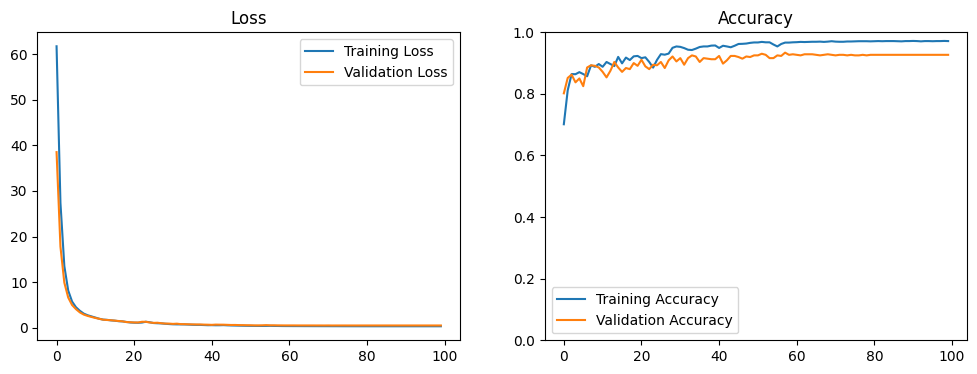

accuracy on test data: 0.913294792175293


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
#plt.ylim(0, 100)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.ylim(0, 1) 
plt.show()
print(f'accuracy on test data: {test_acc}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


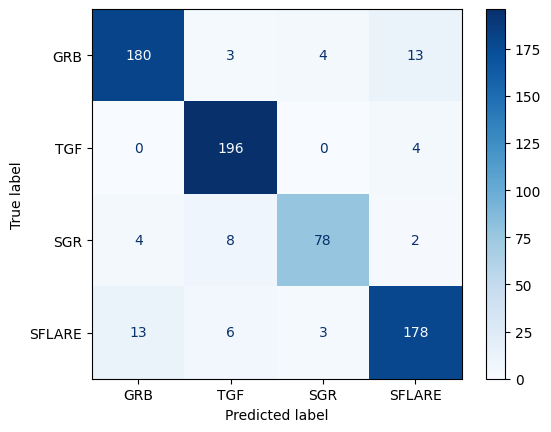

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = ['GRB', 'TGF', 'SGR', 'SFLARE']

test_prediction = model.predict(X_test)
test_predicted_label = np.argmax(test_prediction, axis=1)
test_actual_label = np.argmax(Y_test, axis = 1)
conf_m = confusion_matrix(test_actual_label, test_predicted_label)

conf_m_show = ConfusionMatrixDisplay(confusion_matrix = conf_m,display_labels=class_labels)
conf_m_show.plot(include_values=True, cmap='Blues',ax = None, xticks_rotation= 'horizontal')
plt.show()

In [10]:
for i in range (0,len(test_actual_label) - 1):
    if (test_actual_label[i] == 0 and test_predicted_label[i] == 3):
        print(i)
#print(test_actual_label[8])
#print(test_predicted_label[8])

50
74
116
237
327
332
387
397
398
440
457
498
540
545


In [11]:
from sklearn.metrics import confusion_matrix

#confusion matrix
cm = confusion_matrix(test_actual_label, test_predicted_label)

class_names = ['GRB', 'TGF', 'SGR', 'SFLARE']

num_classes = cm.shape[0]
TP = np.zeros(num_classes)
FP = np.zeros(num_classes)
TN = np.zeros(num_classes)
FN = np.zeros(num_classes)

# Calculate TP, FP, TN, FN for each class
for i in range(num_classes):
    TP[i] = cm[i, i]
    FP[i] = cm[:, i].sum() - cm[i, i]
    FN[i] = cm[i, :].sum() - cm[i, i]
    TN[i] = cm.sum() - (TP[i] + FP[i] + FN[i])

# Display results
for i in range(num_classes):
    print(f"Class {class_names[i]}:")
    print(f"  True Positives: {TP[i]}")
    print(f"  False Positives: {FP[i]}")
    print(f"  True Negatives: {TN[i]}")
    print(f"  False Negatives: {FN[i]}")

Class GRB:
  True Positives: 179.0
  False Positives: 10.0
  True Negatives: 482.0
  False Negatives: 21.0
Class TGF:
  True Positives: 196.0
  False Positives: 20.0
  True Negatives: 472.0
  False Negatives: 4.0
Class SGR:
  True Positives: 80.0
  False Positives: 5.0
  True Negatives: 595.0
  False Negatives: 12.0
Class SFLARE:
  True Positives: 182.0
  False Positives: 20.0
  True Negatives: 472.0
  False Negatives: 18.0


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(test_actual_label, test_predicted_label)

# Class names
class_names = ['GRB', 'TGF', 'SGR', 'SFLARE']

# Lists to hold the file names for TP, FP, FN, TN for each class
TP_files = {class_name: [] for class_name in class_names}
FP_files = {class_name: [] for class_name in class_names}
FN_files = {class_name: [] for class_name in class_names}
TN_files = {class_name: [] for class_name in class_names}

# Loop through each instance in the test set
for i in range(len(test_actual_label)):
    true_class = test_actual_label[i]
    pred_class = test_predicted_label[i]

    # For each class, identify TP, FP, FN, TN
    for class_idx, class_name in enumerate(class_names):
        file_name = test_files[i]  # Get the actual file name
        if true_class == class_idx and pred_class == class_idx:
            TP_files[class_name].append(file_name)  # True Positive
        elif true_class == class_idx and pred_class != class_idx:
            FN_files[class_name].append(file_name)  # False Negative
        elif true_class != class_idx and pred_class == class_idx:
            FP_files[class_name].append(file_name)  # False Positive
        else:
            TN_files[class_name].append(file_name)  # True Negative

# Display results
for class_name in class_names:
    print(f"Class {class_name}:")
    print(f"  \nTrue Positives (TP)({class_name}): {TP_files[class_name]}")
    print(f"  \nFalse Positives (FP)({class_name}): {FP_files[class_name]}")
    print(f"  \nTrue Negatives (TN)({class_name}): {TN_files[class_name]}")
    print(f"  \nFalse Negatives (FN)({class_name}): {FN_files[class_name]}")

Class GRB:
  
True Positives (TP)(GRB): ['/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn171010875', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn220407167', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn100525744', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn120909070', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn151227072', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn110930564', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn101224578', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn131008858', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn151003729', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn150703149', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn150922718', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn121125356', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn201008754', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn210928084', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn111107076', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/GRB_bn150424403',

In [23]:
print(FP_files['GRB'])
for f in (FP_files['GRB']):
    filename_sflares = f.split('/')[-1]  # This gets the last part of the path
    #print(filename_sflares)
    prefix = filename_sflares.split('_')[0]
    if (prefix == 'SFLARE'):
        print(filename_sflares)

print("\n")
print(FP_files['SFLARE'])
for f in (FP_files['SFLARE']):
    filename_grbs = f.split('/')[-1]  # This gets the last part of the path
    prefix = filename_grbs.split('_')[0]
    if (prefix == 'GRB'):
        print(filename_grbs)

['/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn150826485', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn110924857', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SGR_bn150222822', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn140203655', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn160214399', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn150930144', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SGR_bn211209414', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn240123749', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn130217652', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SGR_bn221020008', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn110228470', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn110803292', '/kaggle/input/dcl-ds2new/DCL_ds2new/test/SFLARE_bn140202394']
SFLARE_bn150826485
SFLARE_bn110924857
SFLARE_bn140203655
SFLARE_bn160214399
SFLARE_bn150930144
SFLARE_bn240123749
SFLARE_bn130217652
SFLARE_bn110228470
SFLARE_bn110803292
SFLARE_bn140202394

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


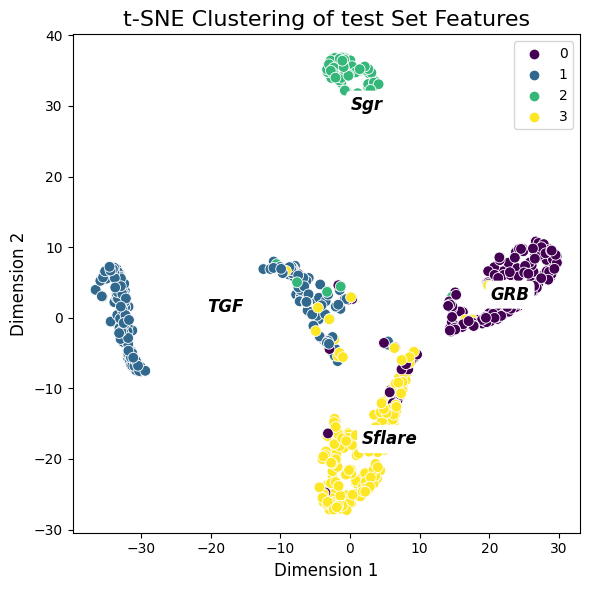

In [36]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Extract features from the penultimate layer
intermediate_layer_model = models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = intermediate_layer_model.predict(X_test)

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
features_2d = tsne.fit_transform(features)
y_true = np.argmax(Y_test, axis=1)

class_names = ['GRB', 'TGF', 'Sgr', 'Sflare']

# Plot the 2D features
plt.figure(figsize=(6, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=y_true, palette="viridis", s=60, marker='o')
# Remove the legend to replace it with custom annotations
for i, class_name in enumerate(class_names):
    # Get the center of each class' points by calculating the mean of their positions
    cluster_center = features_2d[y_true == i].mean(axis=0)
    
    # Add a label near the center of each cluster with an arrow pointing to the cluster
    plt.annotate(class_name, 
                 xy=cluster_center, 
                 xytext=(cluster_center[0] + 0.3, cluster_center[1] + 0.3),  # Offset for the text label
                 arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle="->", lw=1.5),
                 fontsize=12, fontweight='bold', color='black', style='italic',
                 ha='left', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
# Enhance the aesthetics of the plot
plt.title("t-SNE Clustering of test Set Features", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)

# Show the plot with tight layout
plt.tight_layout()
plt.show()


(692, 2)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(692, 4)
[5 3 3 0 2 0 1 1 5 3 5 3 5 3 3 3 3 3 0 3 2 1 5 0 3 2 1 3 0 1 0 2 5 0 2 3 5
 5 2 5 5 0 3 3 0 2 3 2 2 5 3 3 5 0 1 3 0 2 1 2 0 3 3 3 5 1 3 0 1 2 3 1 5 3
 3 2 0 0 0 3 1 3 3 3 3 1 3 5 2 0 5 3 3 1 0 5 0 1 3 3 0 2 2 3 2 3 5 3 3 0 2
 5 3 3 2 1 5 0 1 1 3 1 1 5 0 3 2 1 0 5 3 0 0 3 0 1 3 2 3 0 0 3 0 5 5 0 5 3
 0 1 5 1 1 1 5 5 5 5 5 3 3 1 1 5 5 2 1 0 0 0 5 5 0 3 0 5 3 0 5 0 1 0 2 3 3
 3 1 3 1 3 2 0 0 2 3 2 3 0 1 3 0 0 5 5 1 2 1 1 5 5 0 2 1 0 0 5 0 0 5 3 1 0
 0 3 0 3 1 5 3 3 5 0 3 2 3 0 1 5 0 5 2 3 3 1 0 5 1 0 5 0 0 1 5 5 0 5 3 5 0
 0 0 3 1 3 1 3 1 0 0 5 0 2 2 1 3 2 1 3 2 3 3 3 0 1 3 5 3 5 3 1 0 0 5 0 0 0
 5 1 2 0 3 0 5 5 5 5 5 0 5 1 5 3 1 0 3 3 0 3 2 3 2 0 3 3 0 0 0 5 3 3 3 5 3
 5 3 1 5 2 2 1 3 2 1 1 2 3 0 5 1 5 5 3 0 3 3 5 5 5 5 5 0 5 1 1 0 3 5 2 0 5
 5 5 2 3 2 0 1 2 3 1 5 3 0 0 0 2 5 3 5 3 0 1 3 1 0 0 3 3 0 3 0 3 2 3 1 2 5
 5 5 0 5 3 3 2 0 1 0 3 0 3 5 3 2 5 0 0 3 5 3 2 3 5 5 0 0 5 1 5 0 0 3 0 5 0
 3 1 0 0 2 1 5 1 3 1 3 5 5 5 5 3 5 3 5 1 2

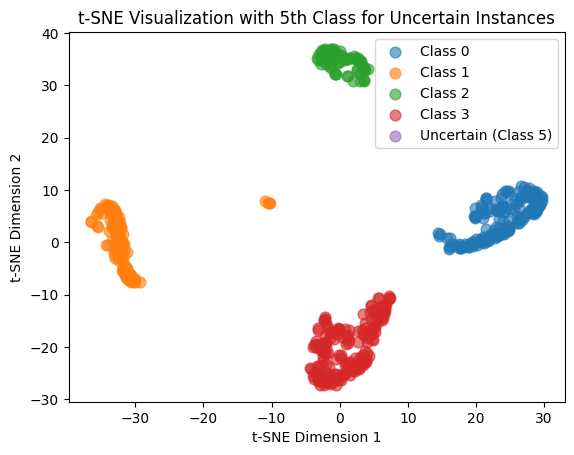

In [51]:
print(features_2d.shape)
y_pred = model.predict(X_test)
print(y_pred.shape)

threshold = 0.95
max_probs = np.max(y_pred, axis=1)
predicted_classes = np.argmax(y_pred, axis=1)

# Create a 5th class label for uncertain instances
class_labels = np.where(max_probs < threshold, 5, predicted_classes)
print(class_labels)
num_class_5_points = np.sum(class_labels == 5)
print(f"Number of points in the 5th class: {num_class_5_points}")
print(f"First 10 max probabilities: {max_probs[:10]}")
print(f"First 10 predicted classes: {predicted_classes[:10]}")
print(f"First 10 class labels: {class_labels[:10]}")
print(f"features_2d shape: {features_2d.shape}")
print(f"class_labels shape: {class_labels.shape}")
assert features_2d.shape[0] == class_labels.shape[0], "Mismatch between features and labels"

# Plotting
plt.figure()

for class_id in range(5):  # Including the 5th class
    class_mask = class_labels == class_id
    plt.scatter(
        features_2d[class_mask, 0],
        features_2d[class_mask, 1],
        label=f'Class {class_id}' if class_id < 4 else 'Uncertain (Class 5)',
        alpha=0.6,
        s=100 if class_id == 5 else 60  
    )

plt.legend()
plt.title("t-SNE Visualization with 5th Class for Uncertain Instances")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

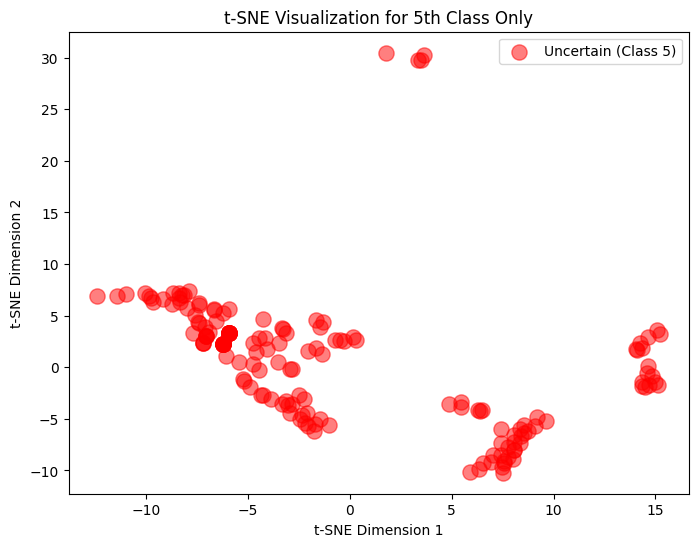

t-SNE coordinates for Class 5:
[[ -7.416551     6.2056966 ]
 [ -6.659387     5.5113587 ]
 [ -4.4824314   -0.22181903]
 [ -7.886002     7.364059  ]
 [ -5.9447074    3.3186173 ]
 [ -5.9447074    3.3186173 ]
 [  6.281793    -4.122795  ]
 [ -4.7328873    2.376774  ]
 [ -5.9447074    3.3186173 ]
 [ -4.7652125    0.2687804 ]
 [  9.110056    -5.7320476 ]
 [ -7.038764     2.9894853 ]
 [ -1.3642296    1.2578204 ]
 [  5.4502954   -3.8114932 ]
 [ -8.7209       6.1268234 ]
 [ -5.9145107    5.6407    ]
 [ 15.090457     3.595308  ]
 [  3.6247435   30.208565  ]
 [ -7.038764     2.9894853 ]
 [  7.7437587   -8.687768  ]
 [ -5.1845965   -1.32782   ]
 [ -2.0349913    1.5860766 ]
 [  5.467117    -3.3551004 ]
 [  8.083784    -7.989104  ]
 [ -7.7189083    3.303075  ]
 [ -3.8658535   -3.0458043 ]
 [ 14.644846     2.961989  ]
 [ 14.484062    -1.9448102 ]
 [  8.412431    -6.654658  ]
 [ -1.4650503    3.9165514 ]
 [ -9.749851     6.7511086 ]
 [ -2.465213    -4.9720526 ]
 [ -2.8529525   -3.5269845 ]
 [ -5.944707

In [53]:
class_5_mask = (class_labels == 5)

plt.figure(figsize=(8, 6))
plt.scatter(
    features_2d[class_5_mask, 0],
    features_2d[class_5_mask, 1],
    color='red',
    s=120,
    alpha=0.5,
    label='Uncertain (Class 5)'
)
plt.legend()
plt.title("t-SNE Visualization for 5th Class Only")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

print(f"t-SNE coordinates for Class 5:\n{features_2d[class_5_mask]}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy on training data with unidentified class: 0.9485714285714286


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Yes
Accuracy on test data with unidentified class: 0.903179190751445
Number of unidentified instances in training data: 58
Number of unidentified instances in test data: 22
confusion matrix


<Figure size 1000x700 with 0 Axes>

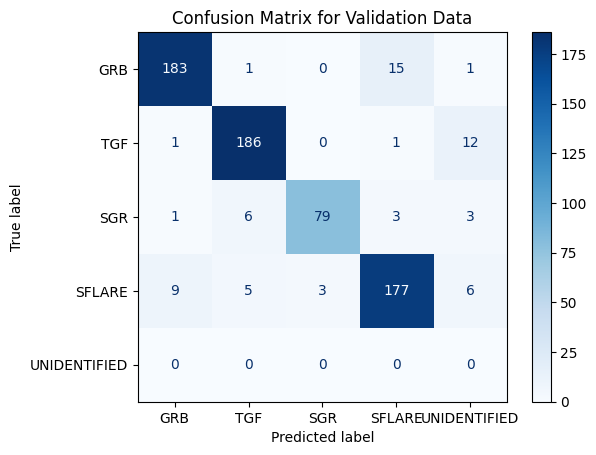

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

threshold = 0.6


def predict_with_unidentified(model, data, threshold=0.6):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, unidentified_count

# Evaluate on training data
train_predictions, train_unidentified_count = predict_with_unidentified(model, X_train, threshold)
train_accuracy = np.mean(train_predictions == np.argmax(Y_train, axis=1))
print(f'\nAccuracy on training data with unidentified class: {train_accuracy}\n\n')

# Evaluate on validation data
test_predictions, test_unidentified_count = predict_with_unidentified(model, X_test, threshold)

# Check if Y_test is one-hot encoded or not
if Y_test.ndim > 1:
    print("Yes")
    test_true_labels = np.argmax(Y_test, axis=1)
else:
    test_true_labels = Y_test

test_accuracy = np.mean(test_predictions == test_true_labels)
print(f'Accuracy on test data with unidentified class: {test_accuracy}')

print(f'Number of unidentified instances in training data: {train_unidentified_count}')
print(f'Number of unidentified instances in test data: {test_unidentified_count}')

print("confusion matrix")
conf_matrix = confusion_matrix(test_true_labels, test_predictions, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNIDENTIFIED'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Data')
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


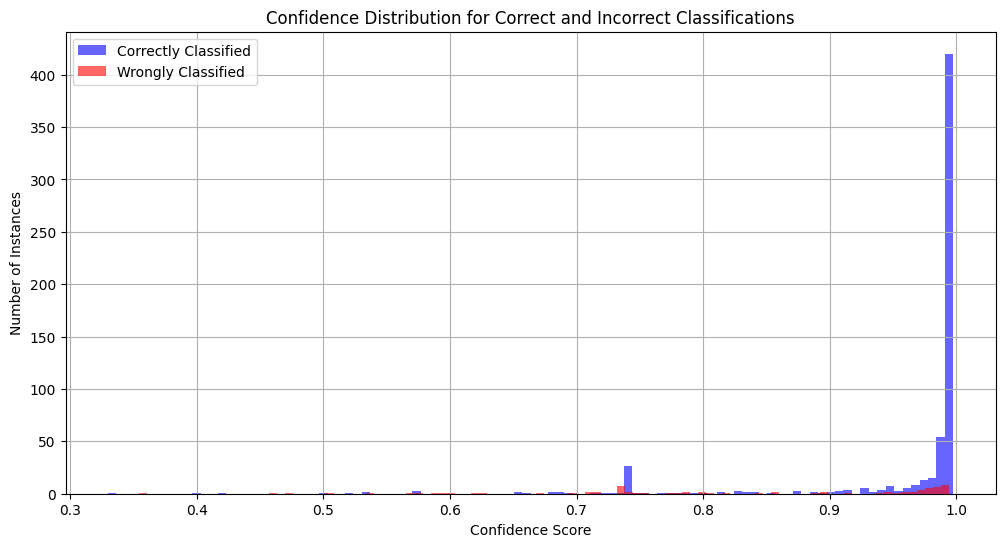

In [26]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(X_test)

# Get the confidence scores (max probability for each instance)
all_confidences = np.max(predictions, axis=1)

# Predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# True labels (assuming Y_test is one-hot encoded or in label form)
if Y_test.ndim == 2:  # If Y_test is one-hot encoded
    true_labels = np.argmax(Y_test, axis=1)
else:
    true_labels = Y_test

# Get confidence scores for correct and incorrect classifications
correct_confidences = all_confidences[predicted_labels == true_labels]
wrong_confidences = all_confidences[predicted_labels != true_labels]

# Plot histograms to visualize confidence score distribution
plt.figure(figsize=(12, 6))

# Histogram for correct classifications
plt.hist(correct_confidences, bins=100, alpha=0.6, color='blue', label='Correctly Classified')

# Histogram for incorrect classifications
plt.hist(wrong_confidences, bins=100, alpha=0.6, color='red', label='Wrongly Classified')

# Adding labels and title
plt.xlabel('Confidence Score')
plt.ylabel('Number of Instances')
plt.title('Confidence Distribution for Correct and Incorrect Classifications')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Input
from sklearn.model_selection import KFold

def create_model(input_shape=(2, 3493)):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # Add layers
    x = layers.Conv1D(512, 1, activation='relu', kernel_regularizer=regularizers.l2(0.02))(inputs)
    x = layers.MaxPooling1D(1)(x)
    x = layers.Conv1D(512, 2, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
    x = layers.MaxPooling1D(1)(x)
    x = layers.LSTM(1024, return_sequences=True, kernel_regularizer=regularizers.l2(0.02))(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model
    
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []
def cross_val_10fold(X, Y, num_folds=10, epochs=100, batch_size=128):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    

    # Cross-validation loop
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]
        
        # Create a fresh model for each fold
        model = create_model(input_shape=(2, 3493))
        
        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Define callbacks (optional)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
        #early_stopping = EarlyStopping(monitor='val_loss', patience=25, min_delta=0.001, restore_best_weights=True, verbose=1)

        # Train the model
        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), 
                            callbacks=[lr_scheduler], verbose=0)
        
        # Record metrics
        train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)
        
        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)
        
    # Calculate average metrics
    avg_train_acc = np.mean(all_train_acc)
    avg_val_acc = np.mean(all_val_acc)
    avg_train_loss = np.mean(all_train_loss)
    avg_val_loss = np.mean(all_val_loss)
    
    print(f'Average Training Accuracy: {avg_train_acc}')
    print(f'Average Validation Accuracy: {avg_val_acc}')
    print(f'Average Training Loss: {avg_train_loss}')
    print(f'Average Validation Loss: {avg_val_loss}')
    
    return avg_train_acc, avg_val_acc, avg_train_loss, avg_val_loss

In [24]:
cross_val_10fold(X_train, Y_train, num_folds=10, epochs=100, batch_size=128)

Average Training Accuracy: 0.9680952310562134
Average Validation Accuracy: 0.9214285731315612
Average Training Loss: 0.3008747696876526
Average Validation Loss: 0.47457104325294497


(0.9680952310562134,
 0.9214285731315612,
 0.3008747696876526,
 0.47457104325294497)

In [27]:
all_val_acc

[0.9392856955528259,
 0.9071428775787354,
 0.9214285612106323,
 0.9142857193946838,
 0.9071428775787354,
 0.9107142686843872,
 0.9357143044471741,
 0.925000011920929,
 0.9321428537368774,
 0.9214285612106323]